# Utilisation d'un Monte Carlo pour prédire la meilleure stratégie de BlackJack

In [6]:
import sys
import gym
import numpy as np
from collections import defaultdict
from plot_utils import plot_blackjack_values, plot_policy

In [7]:
env = gym.make('Blackjack-v1')

In [8]:
"""
    Get the probability of taking the best known action according to epsilon.
    Returns the policy for the Q value given
"""
def get_probs(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

"""
    returns the best actions for each Q value in the policy
"""
def best_policy(Q):
    return dict((k,np.argmax(v)) for k, v in Q.items())
"""
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
"""
def create_greedy_policy(Q):   
    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A[best_action] = 1.0
        return A
    return policy_fn

def epsilon_greedy(Q, epsilon, nA):
    if np.random.rand() < epsilon:
        return np.random.choice(nA)  # Choose a random action with probability epsilon
    else:
        return np.argmax(Q)  # Choose the action with the highest estimated value according to Q

"""
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
"""
def create_random_policy(nA): # Policy where all actions are equally likely 
    A = np.ones(nA, dtype=float) / nA
    def policy_fn():
        return A
    return policy_fn

## Policy Update Methods
Calculate the new Q values for the actions taken in the given episode.
    Returns the new Q policy. Implementations are in the following order :
    - First visit, implemented by Donal Byrne
    - Every vist, our own work
    - Weight Importance Sampling (WIS), our own work

In [9]:
def update_Q_first_visit(episode, Q, alpha, gamma):
    visited = set()  # Keep track of visited state-action pairs
    for t, (state, action, reward) in enumerate(episode):
        if (state, action) not in visited:
            G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[t:])])
            Q[state][action] = Q[state][action] + alpha*(G - Q[state][action])
            visited.add((state, action))
    return Q

def update_Q_every_visit(episode, Q, alpha, gamma):
    for t, (state, action, reward) in enumerate(episode):
        G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[t:])])
        Q[state][action] = Q[state][action] + alpha*(G - Q[state][action])
    return Q

def update_Q_wis(C, Q, behavior_policy, episode, gamma, states, target_policy):
    # Sum of discounted returns
    G = 0.0
    # The importance sampling ratio (the weights of the returns)
    weight_ratio = 1.0
    # For each step in the episode, backwards
    for t in range(len(episode))[::-1]:
        state, action, reward = episode[t]
        states.add(state)
        # Update the total reward since step t
        G = gamma * G + reward
        # Update weighted importance sampling formula denominator
        C[state][action] += weight_ratio
        # This also improves our target policy which holds a reference to Q
        Q[state][action] += (weight_ratio / C[state][action]) * (G - Q[state][action])
        # If the action taken by the behavior policy is not the action 
        # taken by the target policy the probability will be 0 and we can break
        if action != np.argmax(target_policy(state)):
            break
        weight_ratio = weight_ratio * 1. / behavior_policy()[action]
    return Q,C,states

## Do a episode

Play a game and return the episode, containing results
    Implementations are in the following order :
    - First visit, implemented by Donal Byrne
    - Every vist, our own work
    - Weight Importance Sampling, our own work

In [10]:
def play_game_first_visit(env, Q, epsilon, nA):
    episode = []
    state = env.reset()
    visited = set()  # Keep track of visited state-action pairs
    terminated = False
    while not terminated:
        if type(state[0]) == tuple:
            state = state[0]
        action = epsilon_greedy(Q[state], epsilon, nA)
        next_state, reward, terminated, truncated,info = env.step(action)
        if (state, action) not in visited:
            episode.append((state, action, reward))
        visited.add((state, action))  # Mark this state-action pair as visited
        state = next_state    
    return episode


def play_game_every_visit(env, Q, epsilon, nA):
    episode = []
    state = env.reset()
    terminated = False
    while not terminated:
        if type(state[0]) == tuple:
            state = state[0]
        action = epsilon_greedy(Q[state], epsilon, nA)
        next_state, reward, terminated, truncated,info  = env.step(action)
        episode.append((state, action, reward))
        
        state = next_state    
    return episode


def play_game_wis(behavior_policy, env):
    episode = []
    state = env.reset()
    terminated = False
    while not terminated:
        if type(state[0]) == tuple:
            state = state[0]
        probs = behavior_policy()
        action = np.random.choice(np.arange(len(probs)), p=probs)
        next_state, reward, terminated, trunc, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
    return episode

## Launch the monte Carlo

Those methods are used for displaying results for all runs

In [11]:
def display_policy(policy):
    new_policy = {}
    for key, value in policy.items():
        new_policy[(key[1], key[0], key[2])] = value
    plot_policy(new_policy)
    
def display_policy_wis(policy_function,states):
    weighted_policy = {(i[1], i[0], i[2]): np.argmax(policy_function(i)) for i in states}
    plot_policy(weighted_policy)

This cell contains all methods needed to run every monte-carlo.
Iterates through episodes, retrieves the list of states, actions and rewards from the last episode and use them to calculate the updated Q values.

This method is based on the code of Donal Bryne, and was adapted to fit to our code, and being able to launch every monte carlo variante depending on parameters

In [12]:
def mc_control(env, num_episodes,first_visit=True, behavior_policy=None,gamma=.8,list_prints=[]): 
    epsilon = .8
    eps_min = 0.01
    decay = 0.99
    alpha = 0.001
    
    nA = env.action_space.n # The final action-value function.
    Q = defaultdict(lambda: np.zeros(nA))
    weigth_importance_sampling = False
    if behavior_policy != None:
        # The cumulative denominator of the weighted importance sampling formula,across all episodes
        C = defaultdict(lambda: np.zeros(nA))
        states = set()
        # Our greedily policy we want to learn
        target_policy = create_greedy_policy(Q)
        first_visit = False
        weigth_importance_sampling = True
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0: # Go throug episodes
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        if i_episode in list_prints:
            print(f'A l\'episode {i_episode}')
            if weigth_importance_sampling:
                display_policy_wis(target_policy,states)
            else:
                display_policy(best_policy(Q))
            
        epsilon = max(epsilon*decay, eps_min)
        if weigth_importance_sampling:
            episode = play_game_wis(behavior_policy, env)
            Q,C,states = update_Q_wis(C, Q, behavior_policy, episode, gamma, states, target_policy)
        elif first_visit:
            episode = play_game_first_visit(env, Q, epsilon, nA)
            Q = update_Q_first_visit(episode, Q, alpha, gamma)
        else:
            episode = play_game_every_visit(env, Q, epsilon, nA)
            Q = update_Q_every_visit(episode, Q, alpha, gamma)
    if weigth_importance_sampling:
        return target_policy, Q,states
    else:
        policy = best_policy(Q)
        return policy, Q
    
def launch_monte_carlo(nb_episodes, first_visit=True, gamma=.8, list_prints=None):
    if list_prints is None:
        list_prints = []
    policy, Q = mc_control(env, nb_episodes, first_visit,gamma=gamma, list_prints=list_prints)
    V = dict((k,np.max(v)) for k, v in Q.items())
    plot_blackjack_values(V)
    display_policy(policy)


def launch_monte_carlo_wis(behavior_policy,nb_episodes=500000, gamma=.8,list_prints=None):
    policy_weighted, Q_weighted, states_weighted = mc_control(env, nb_episodes,behavior_policy=behavior_policy,gamma=gamma,list_prints=list_prints)
    V_weigthed = dict((k, np.max(v)) for k, v in Q_weighted.items())
    plot_blackjack_values(V_weigthed)
    display_policy_wis(policy_weighted,states_weighted)

# Resulats et comparaisons

### First-visit on-policy 

/home/theojeannes/Dev/Scolaire/AppParRenforcement/python/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


A l'episode 100


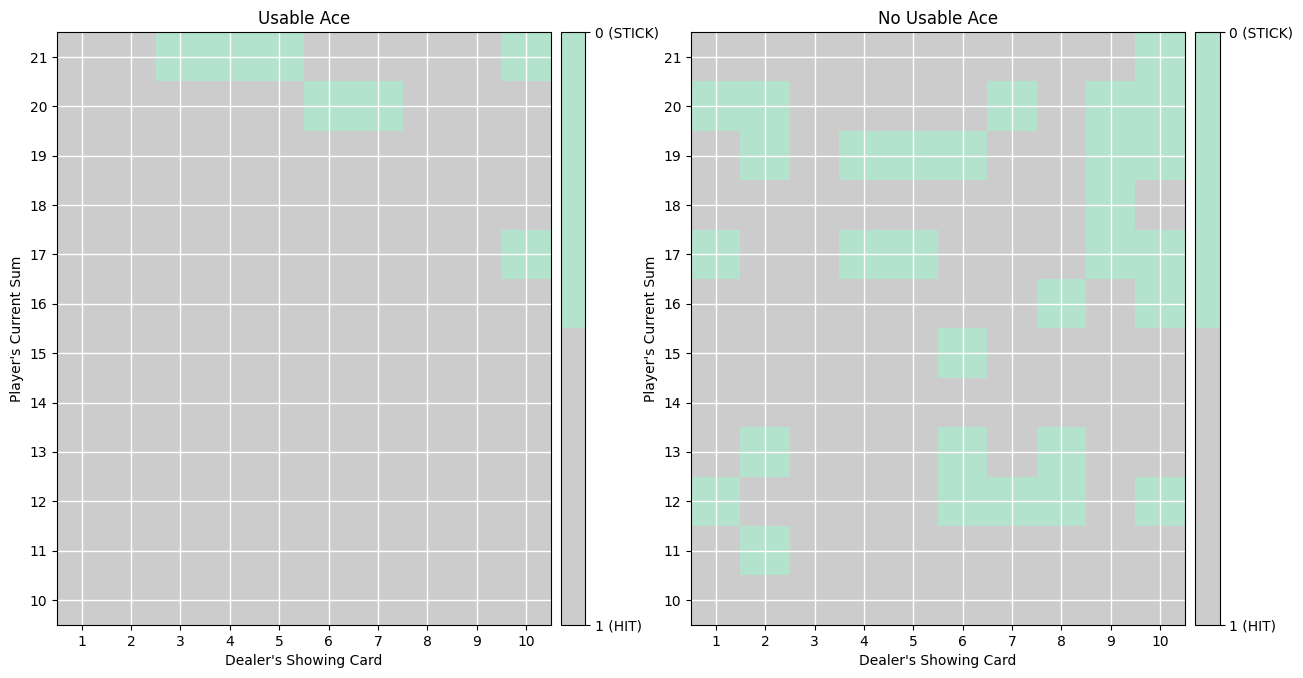

Episode 10000/500000.A l'episode 10000


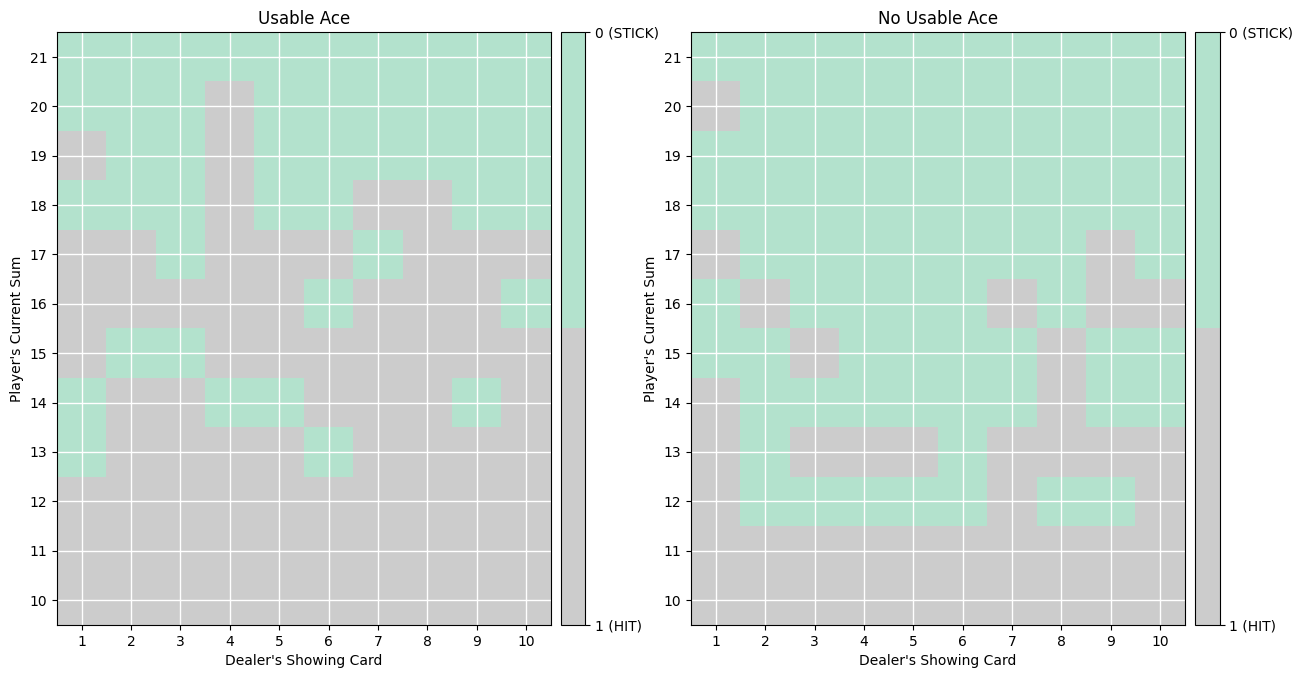

Episode 100000/500000.A l'episode 100000


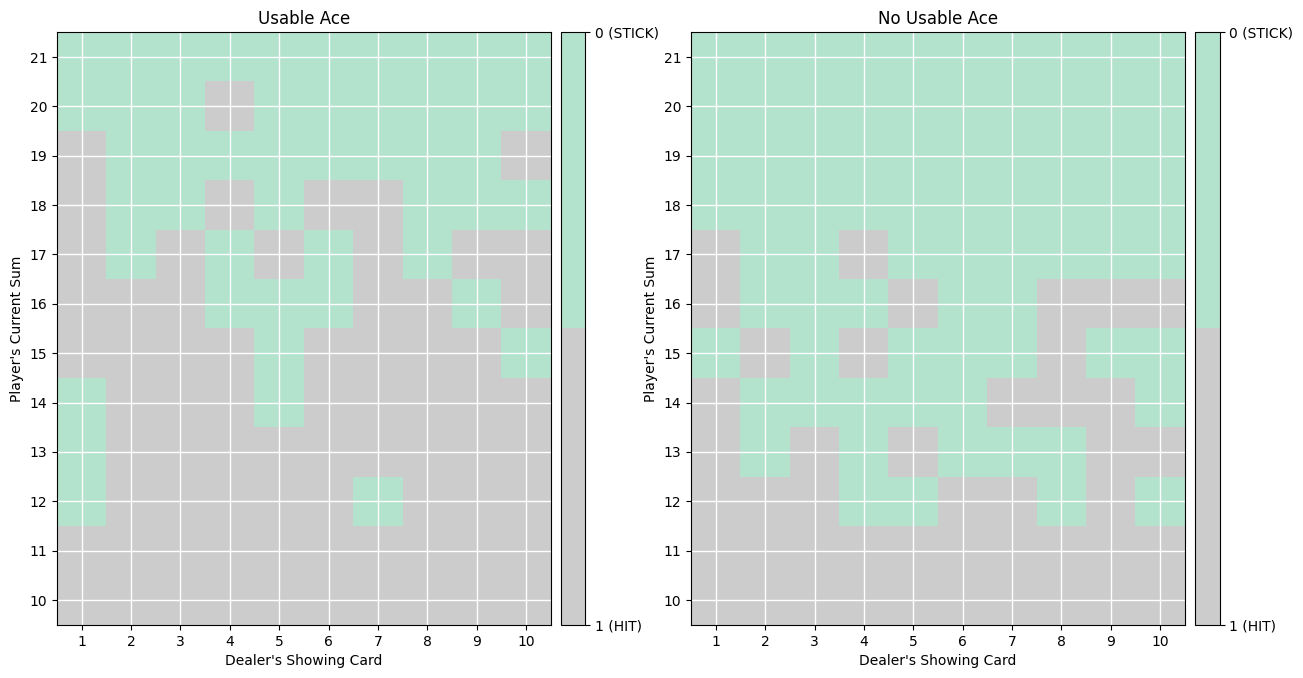

Episode 500000/500000.

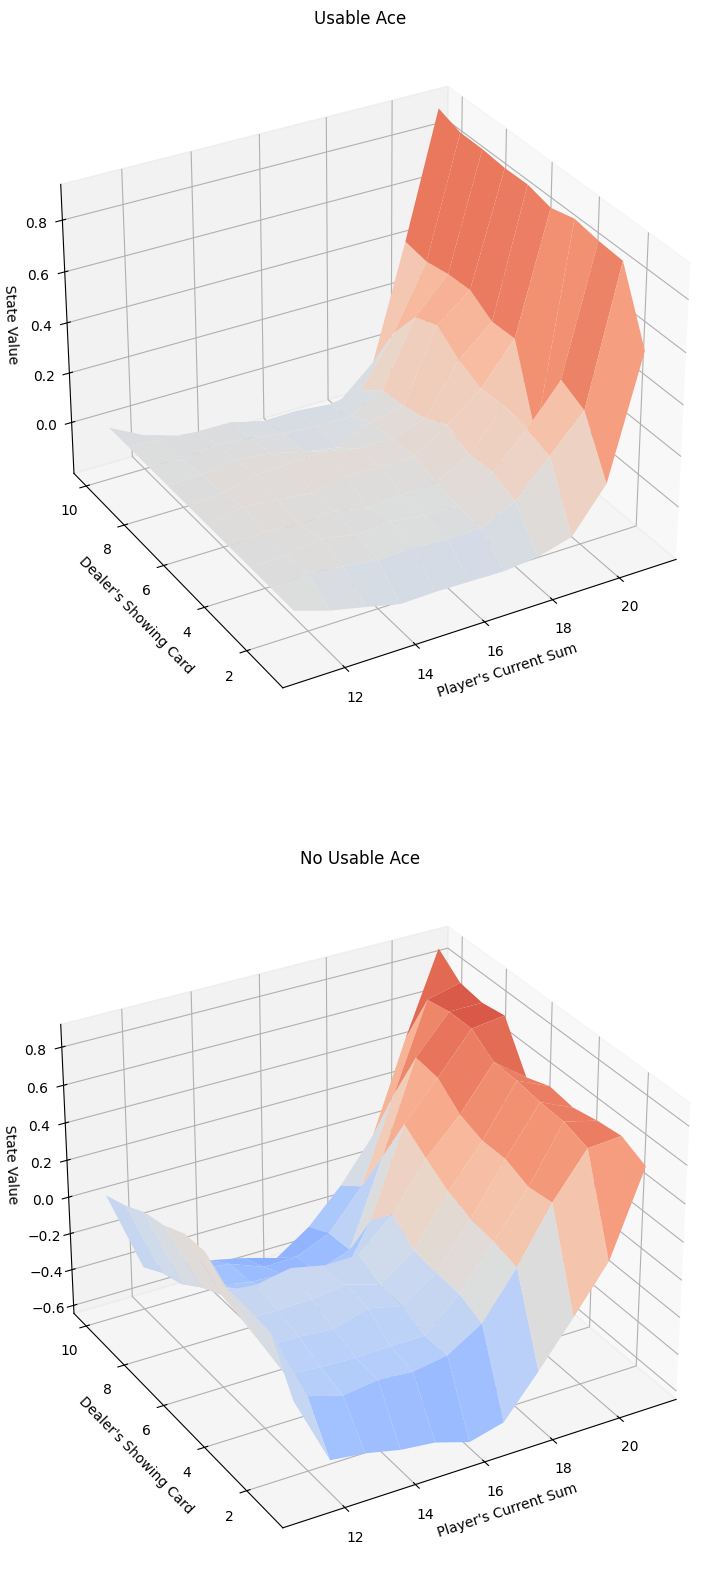

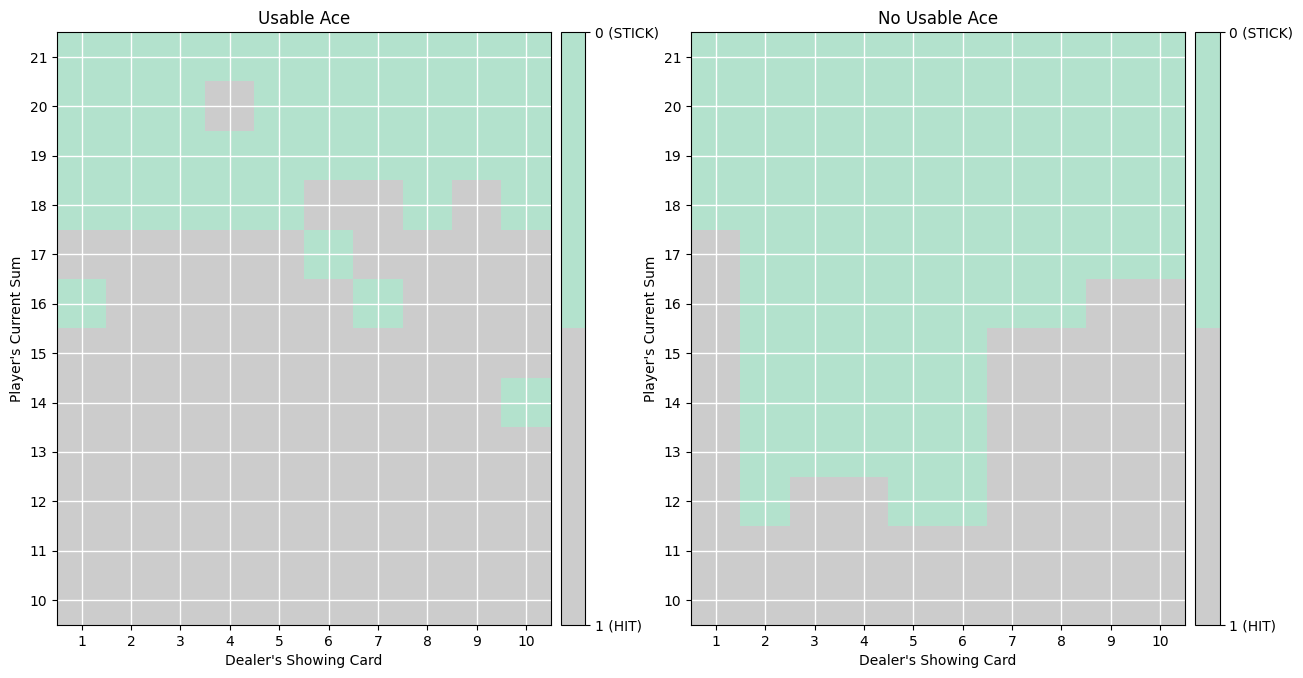

In [13]:
launch_monte_carlo(500000,list_prints=[100,10000,100000])

### Every-visit on-policy

A l'episode 100


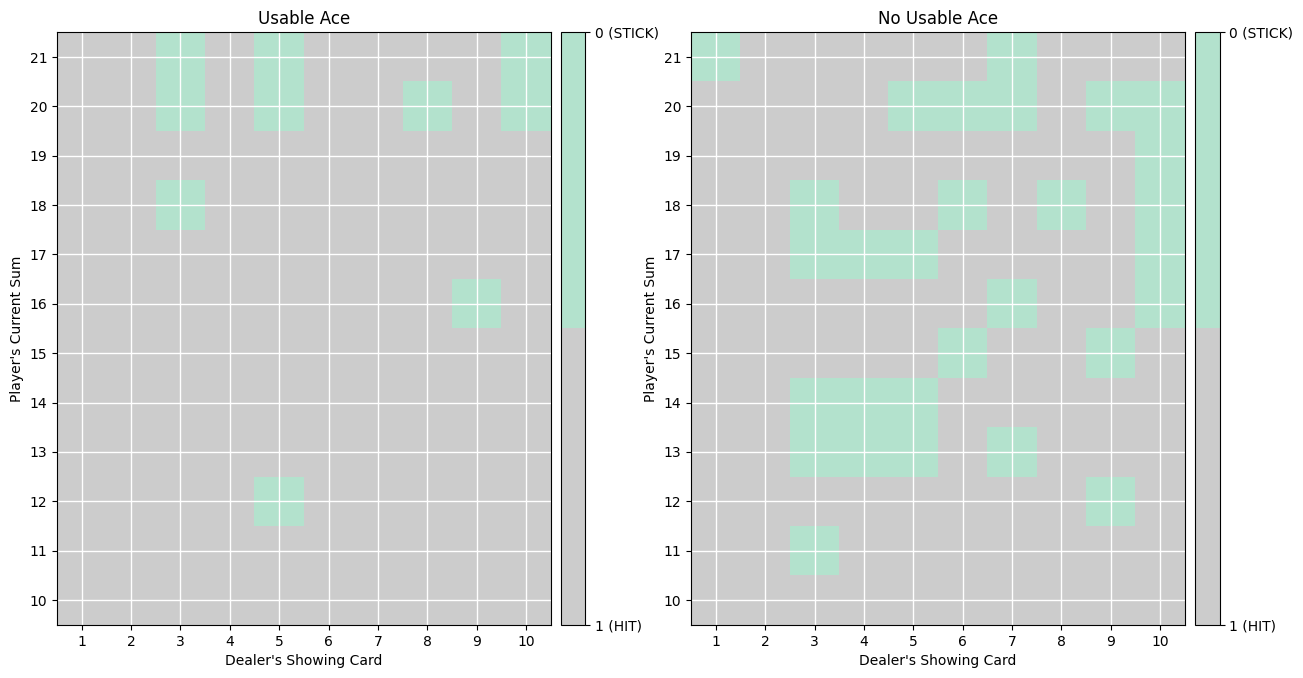

Episode 10000/500000.A l'episode 10000


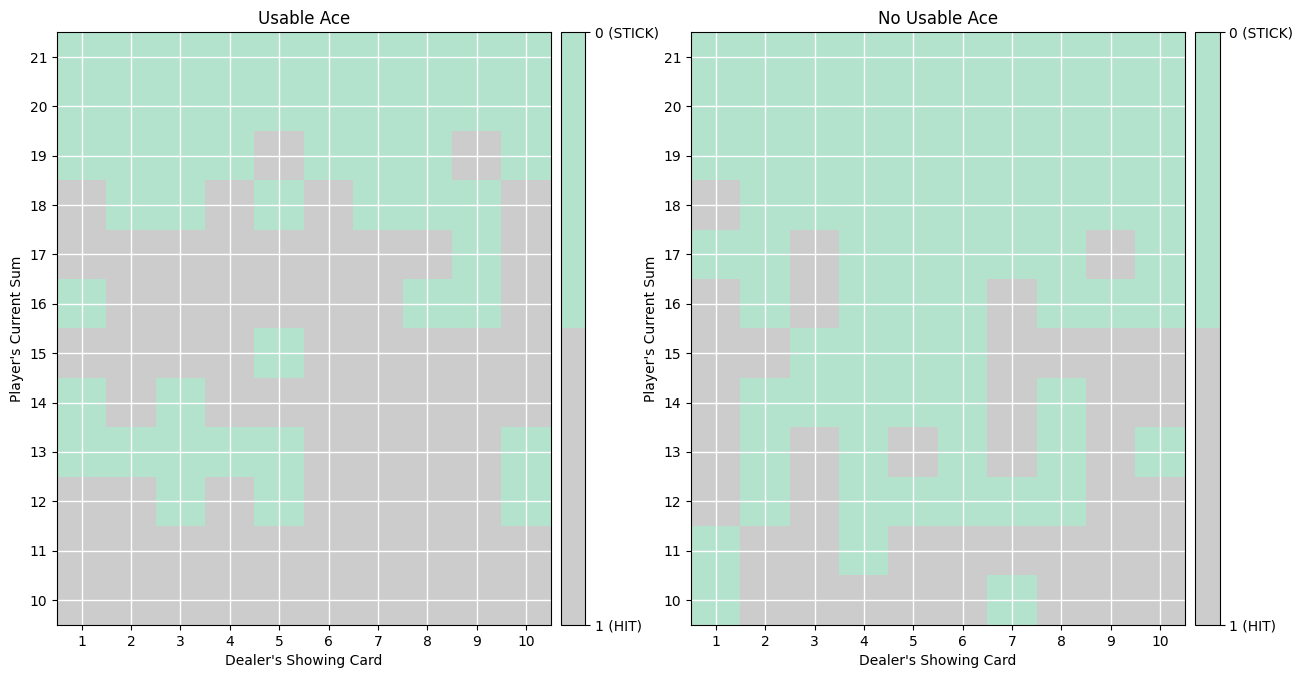

Episode 100000/500000.A l'episode 100000


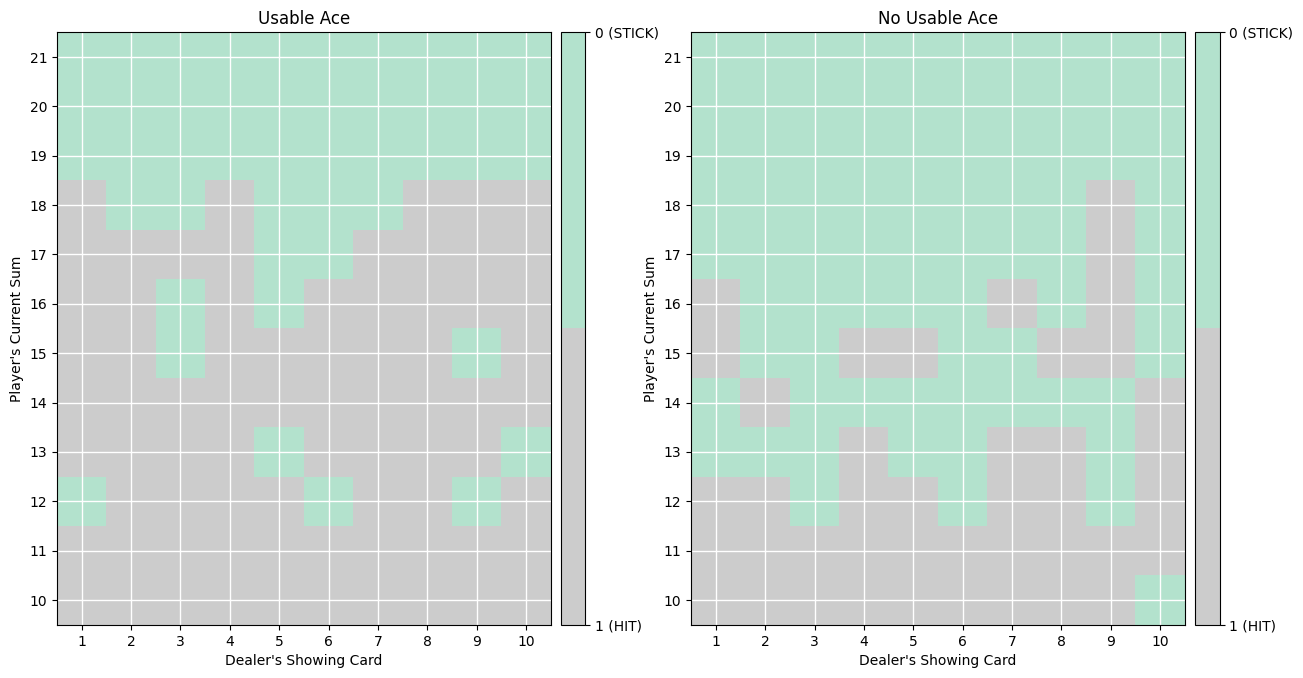

Episode 500000/500000.

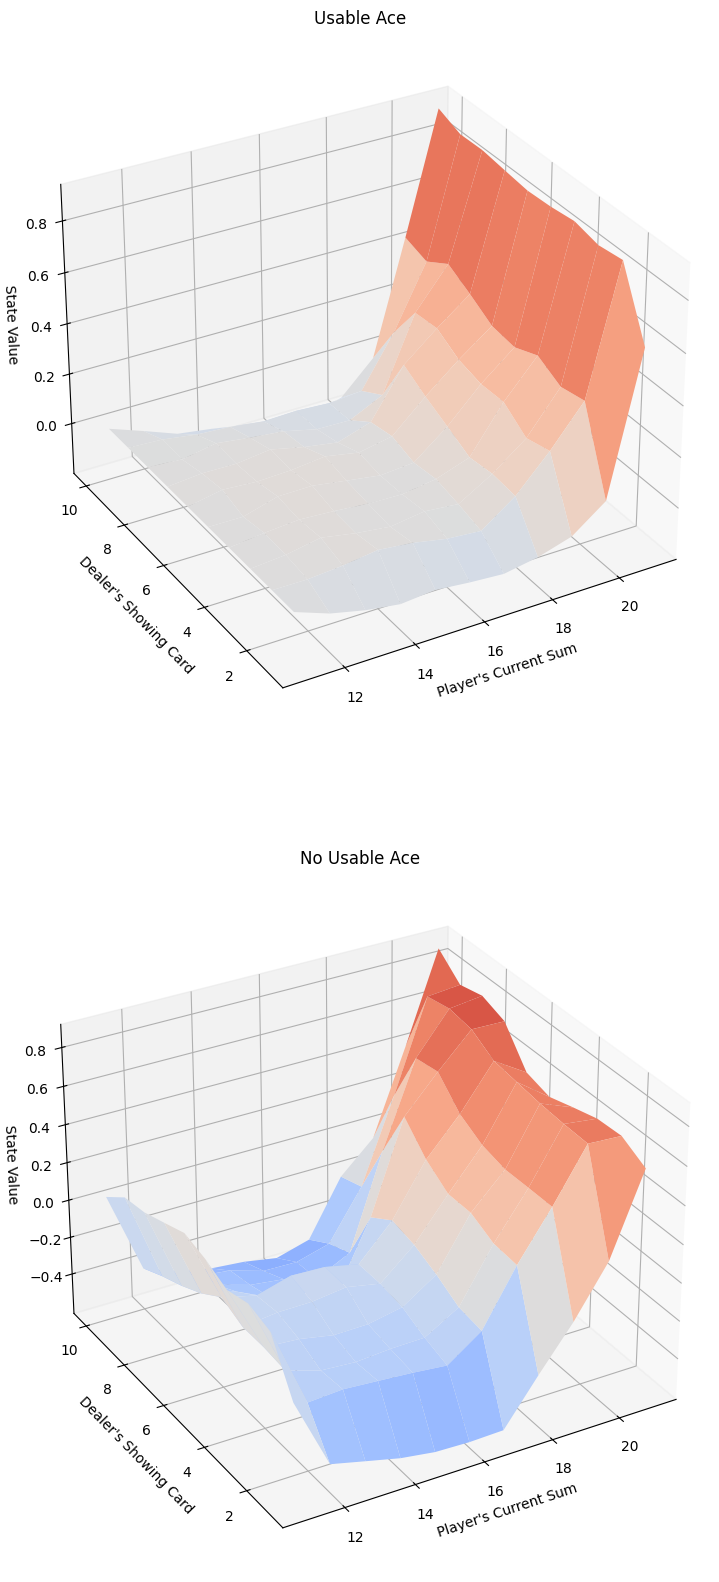

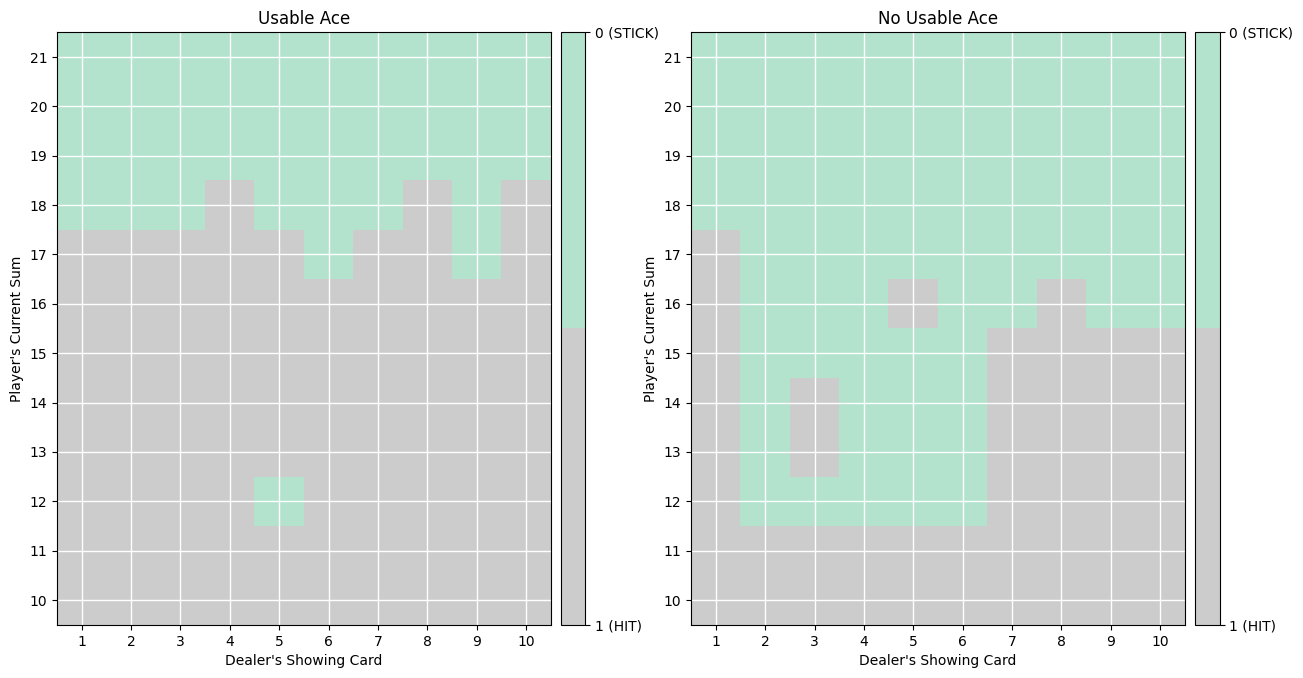

In [14]:
launch_monte_carlo(500000, False,list_prints=[100,10000,100000])

### First-visit Off-policy Weigth Importance Sampling

A l'episode 100


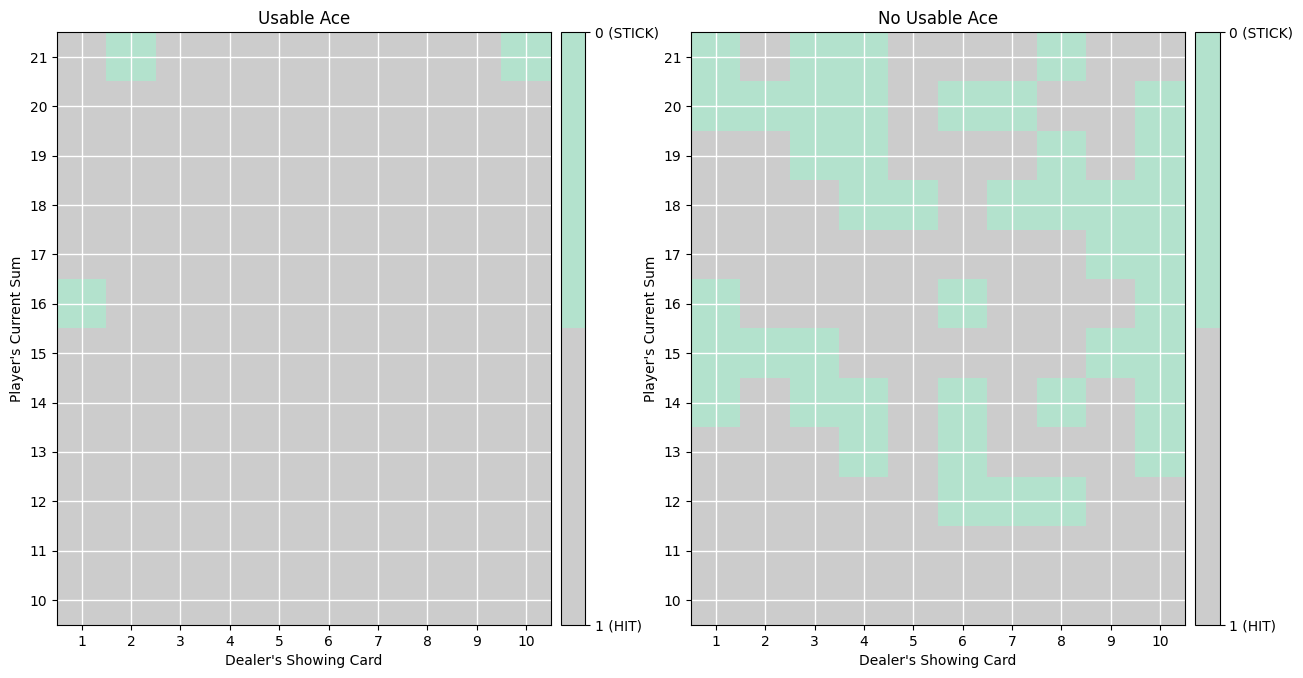

Episode 10000/500000.A l'episode 10000


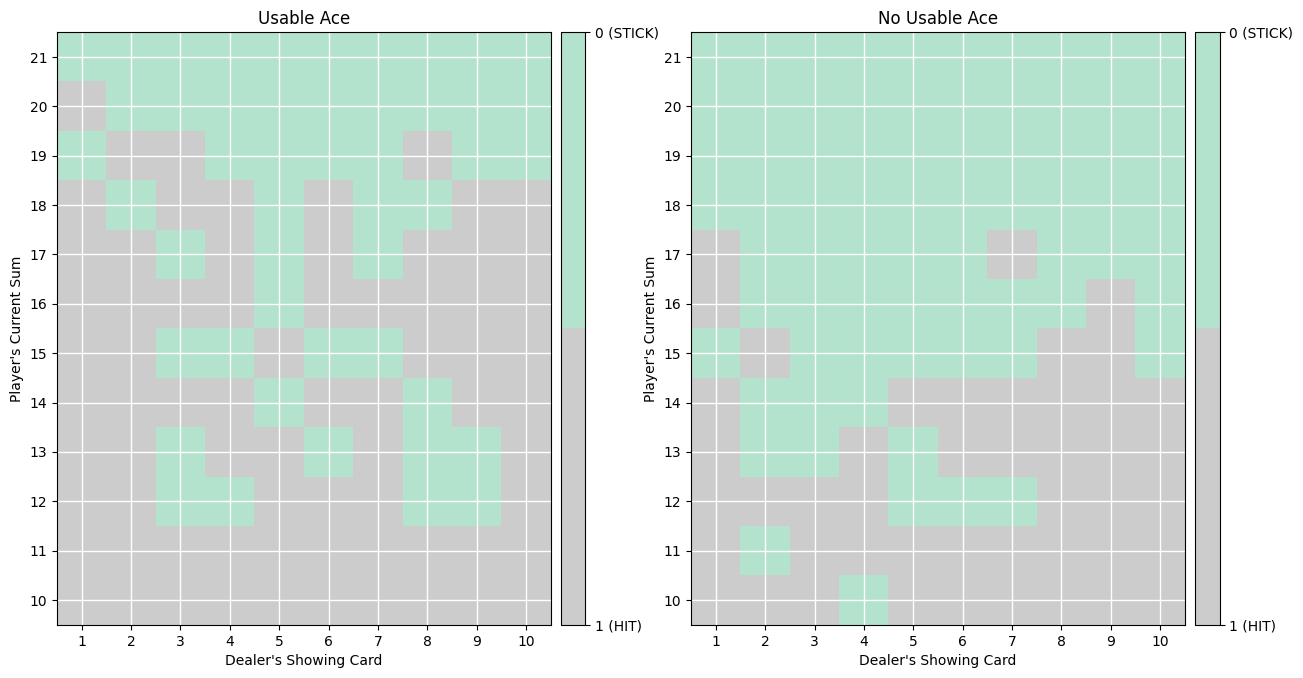

Episode 100000/500000.A l'episode 100000


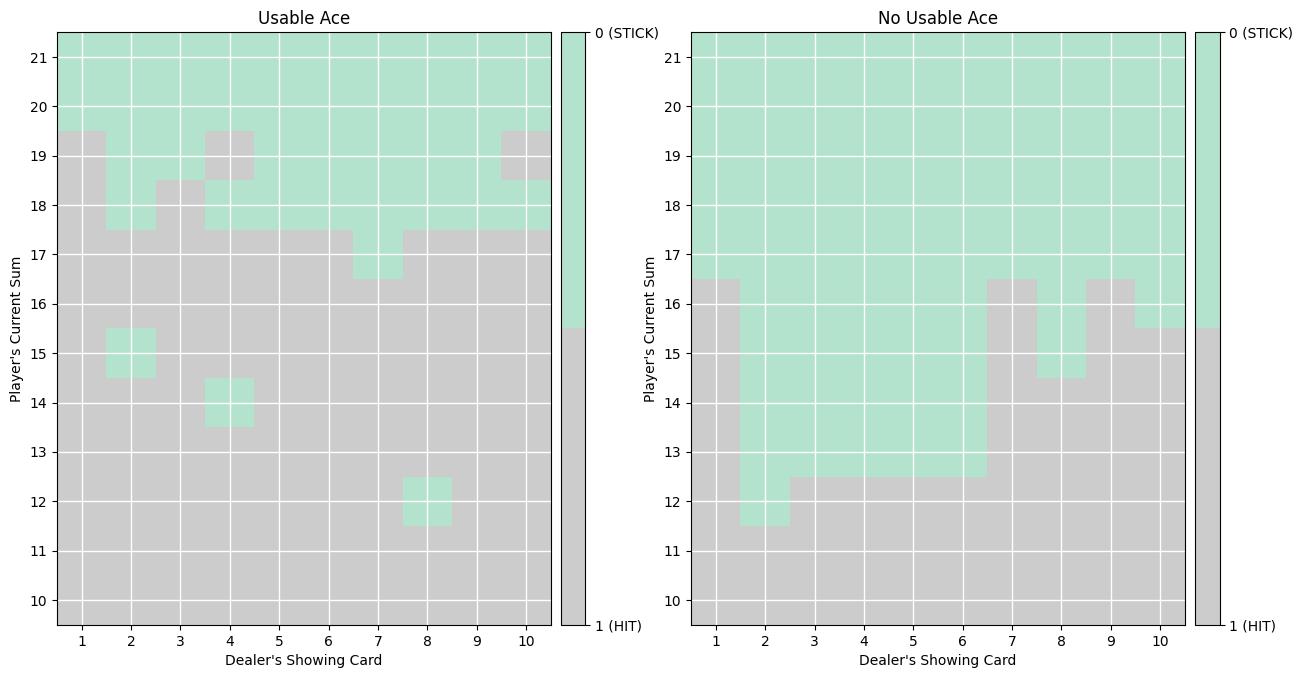

Episode 500000/500000.

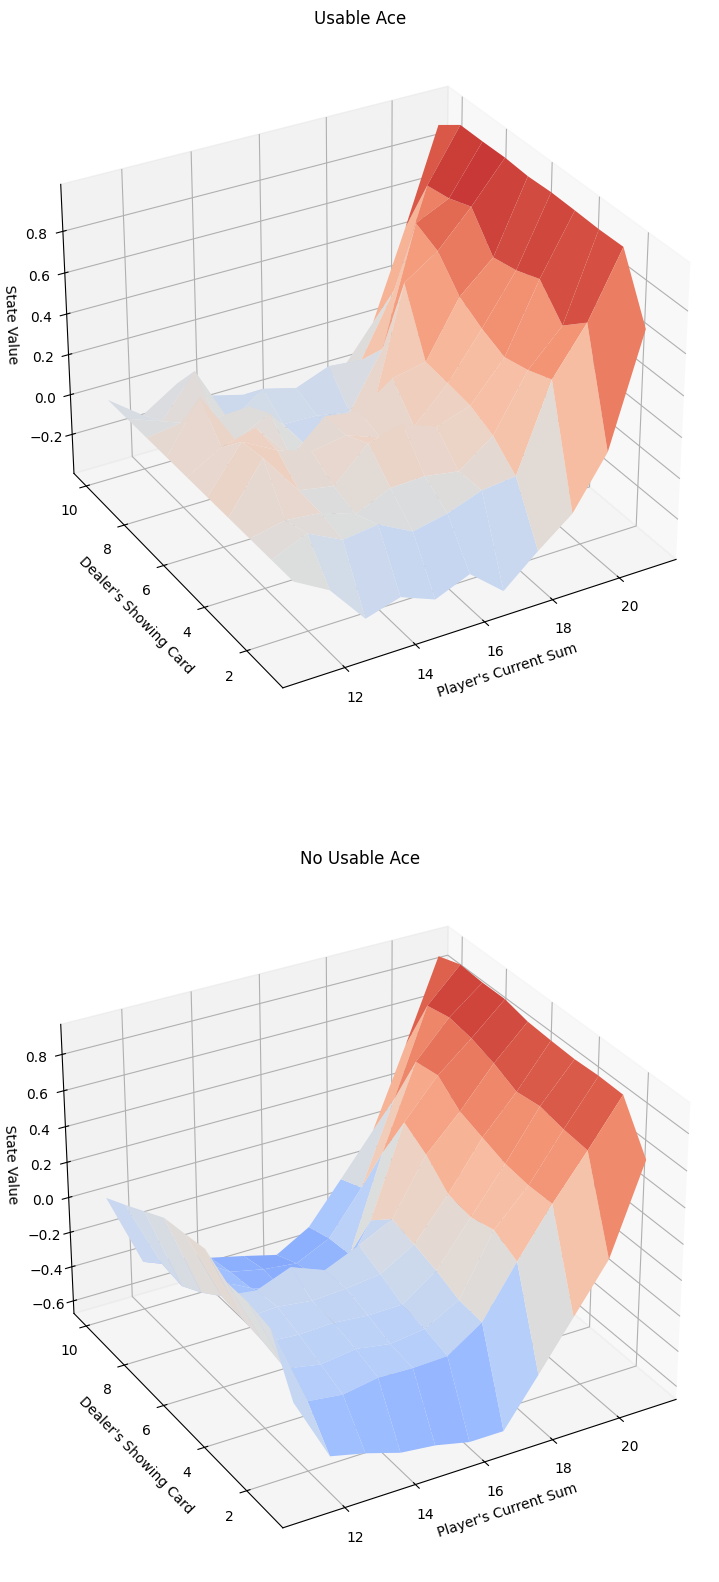

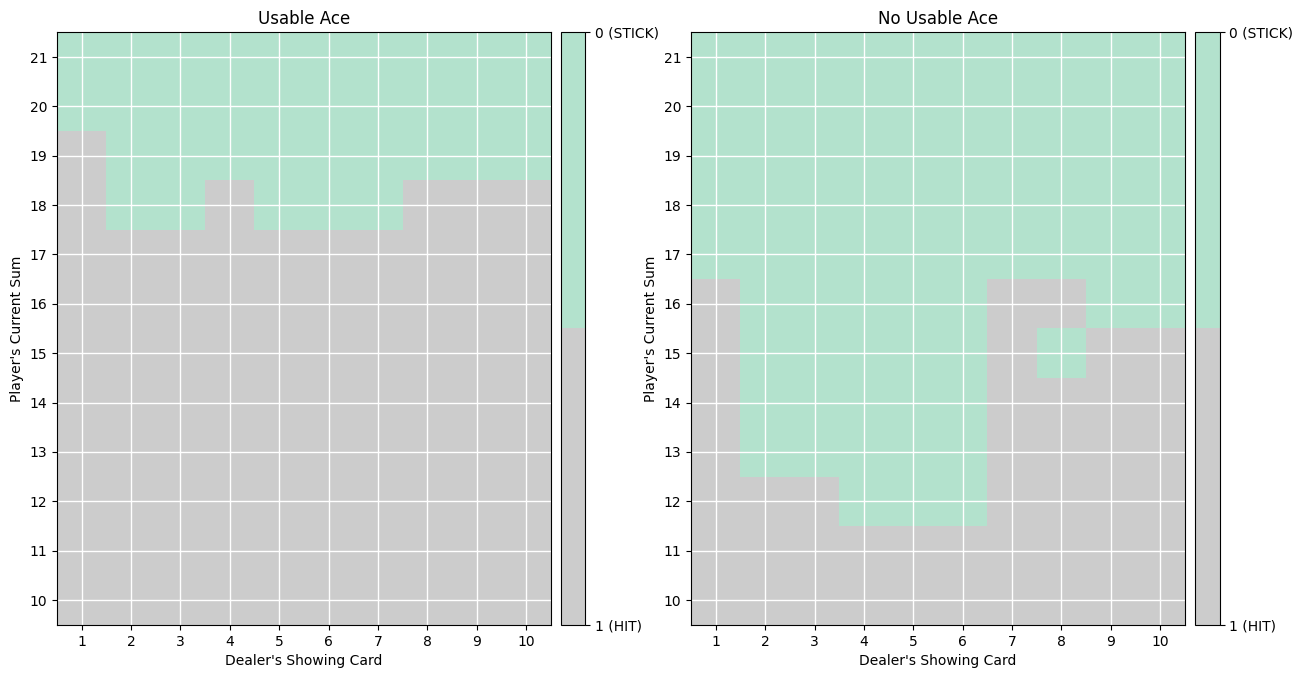

In [15]:
random_policy = create_random_policy(env.action_space.n)
launch_monte_carlo_wis(random_policy,list_prints=[100,10000,100000])